<a href="https://colab.research.google.com/github/vikram182003/CODSOFT-MACHINE-LEARNING/blob/main/Arrhythmia_Classification_Full_and_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**

In [2]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.4 MB/s eta 0:00:00


In [ ]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

## **A2: Basic Visualization of ECG**
Basic code for loading (reading), plotting and playing with ECG signals

### **a. Getting Recordings' IDs**
The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings.

In [ ]:
RECORDS="/content/RECORDS"
patient_ids = pd.read_csv(RECORDS, delimiter="\n", header=None).to_numpy().reshape(-1)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

### **b. 1 Patient ECG loading and plotting**
Extracting 2 leads ECG signals of a patient (for example: 100), and saving in two lists.

In [ ]:
#Extracting just 1 patient ECG signal and info
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
DATA_ROOT="/content/RECORDS"
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

### **c. All patients' ECG loading**

In [ ]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [ ]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [ ]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

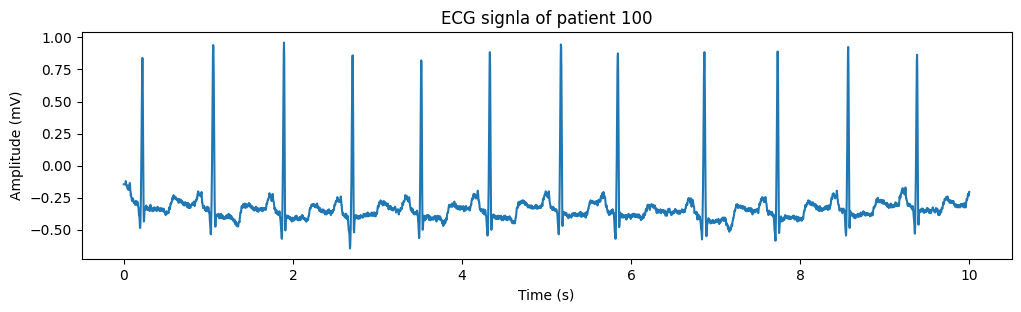

In [ ]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]



# **Part B: Denoising, R-Peak Detection, Segmentation**

### **B1: Denoising**
Noise removing by using Discrete Wavelet Transform (DCT)

In [ ]:
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

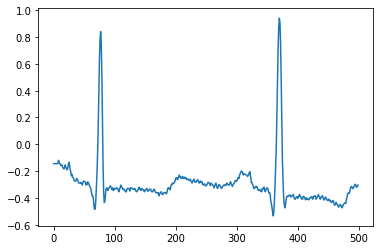

In [ ]:
# Ploting a signal before denoising
project_path="/content/RECORDS"
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

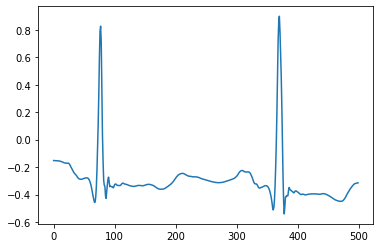

In [ ]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

### **B2: R-Peak Detection**
R-peak is annotated in MIT-BIH dataset. Just need to read the file.

In [ ]:
# For exmaple, we extract '100' recording annotation
project_path=""
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

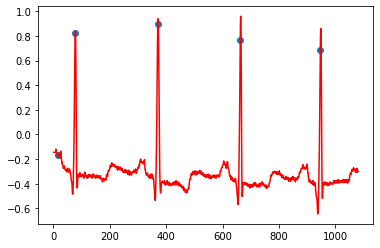

In [ ]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

### **B3: Segmentation**


(300,)
(300,)
(300,)


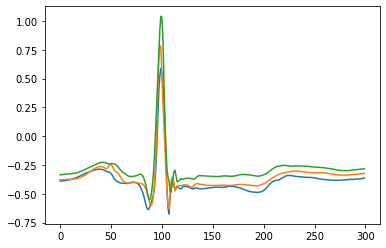

In [ ]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

### **B4: Complete Preprocessing Figures**
The complete preprocessing including denosinsing, R-peak location detection and segmentation is expected to view in a single figure.

In [ ]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

In [1]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

NameError: name 'plt' is not defined

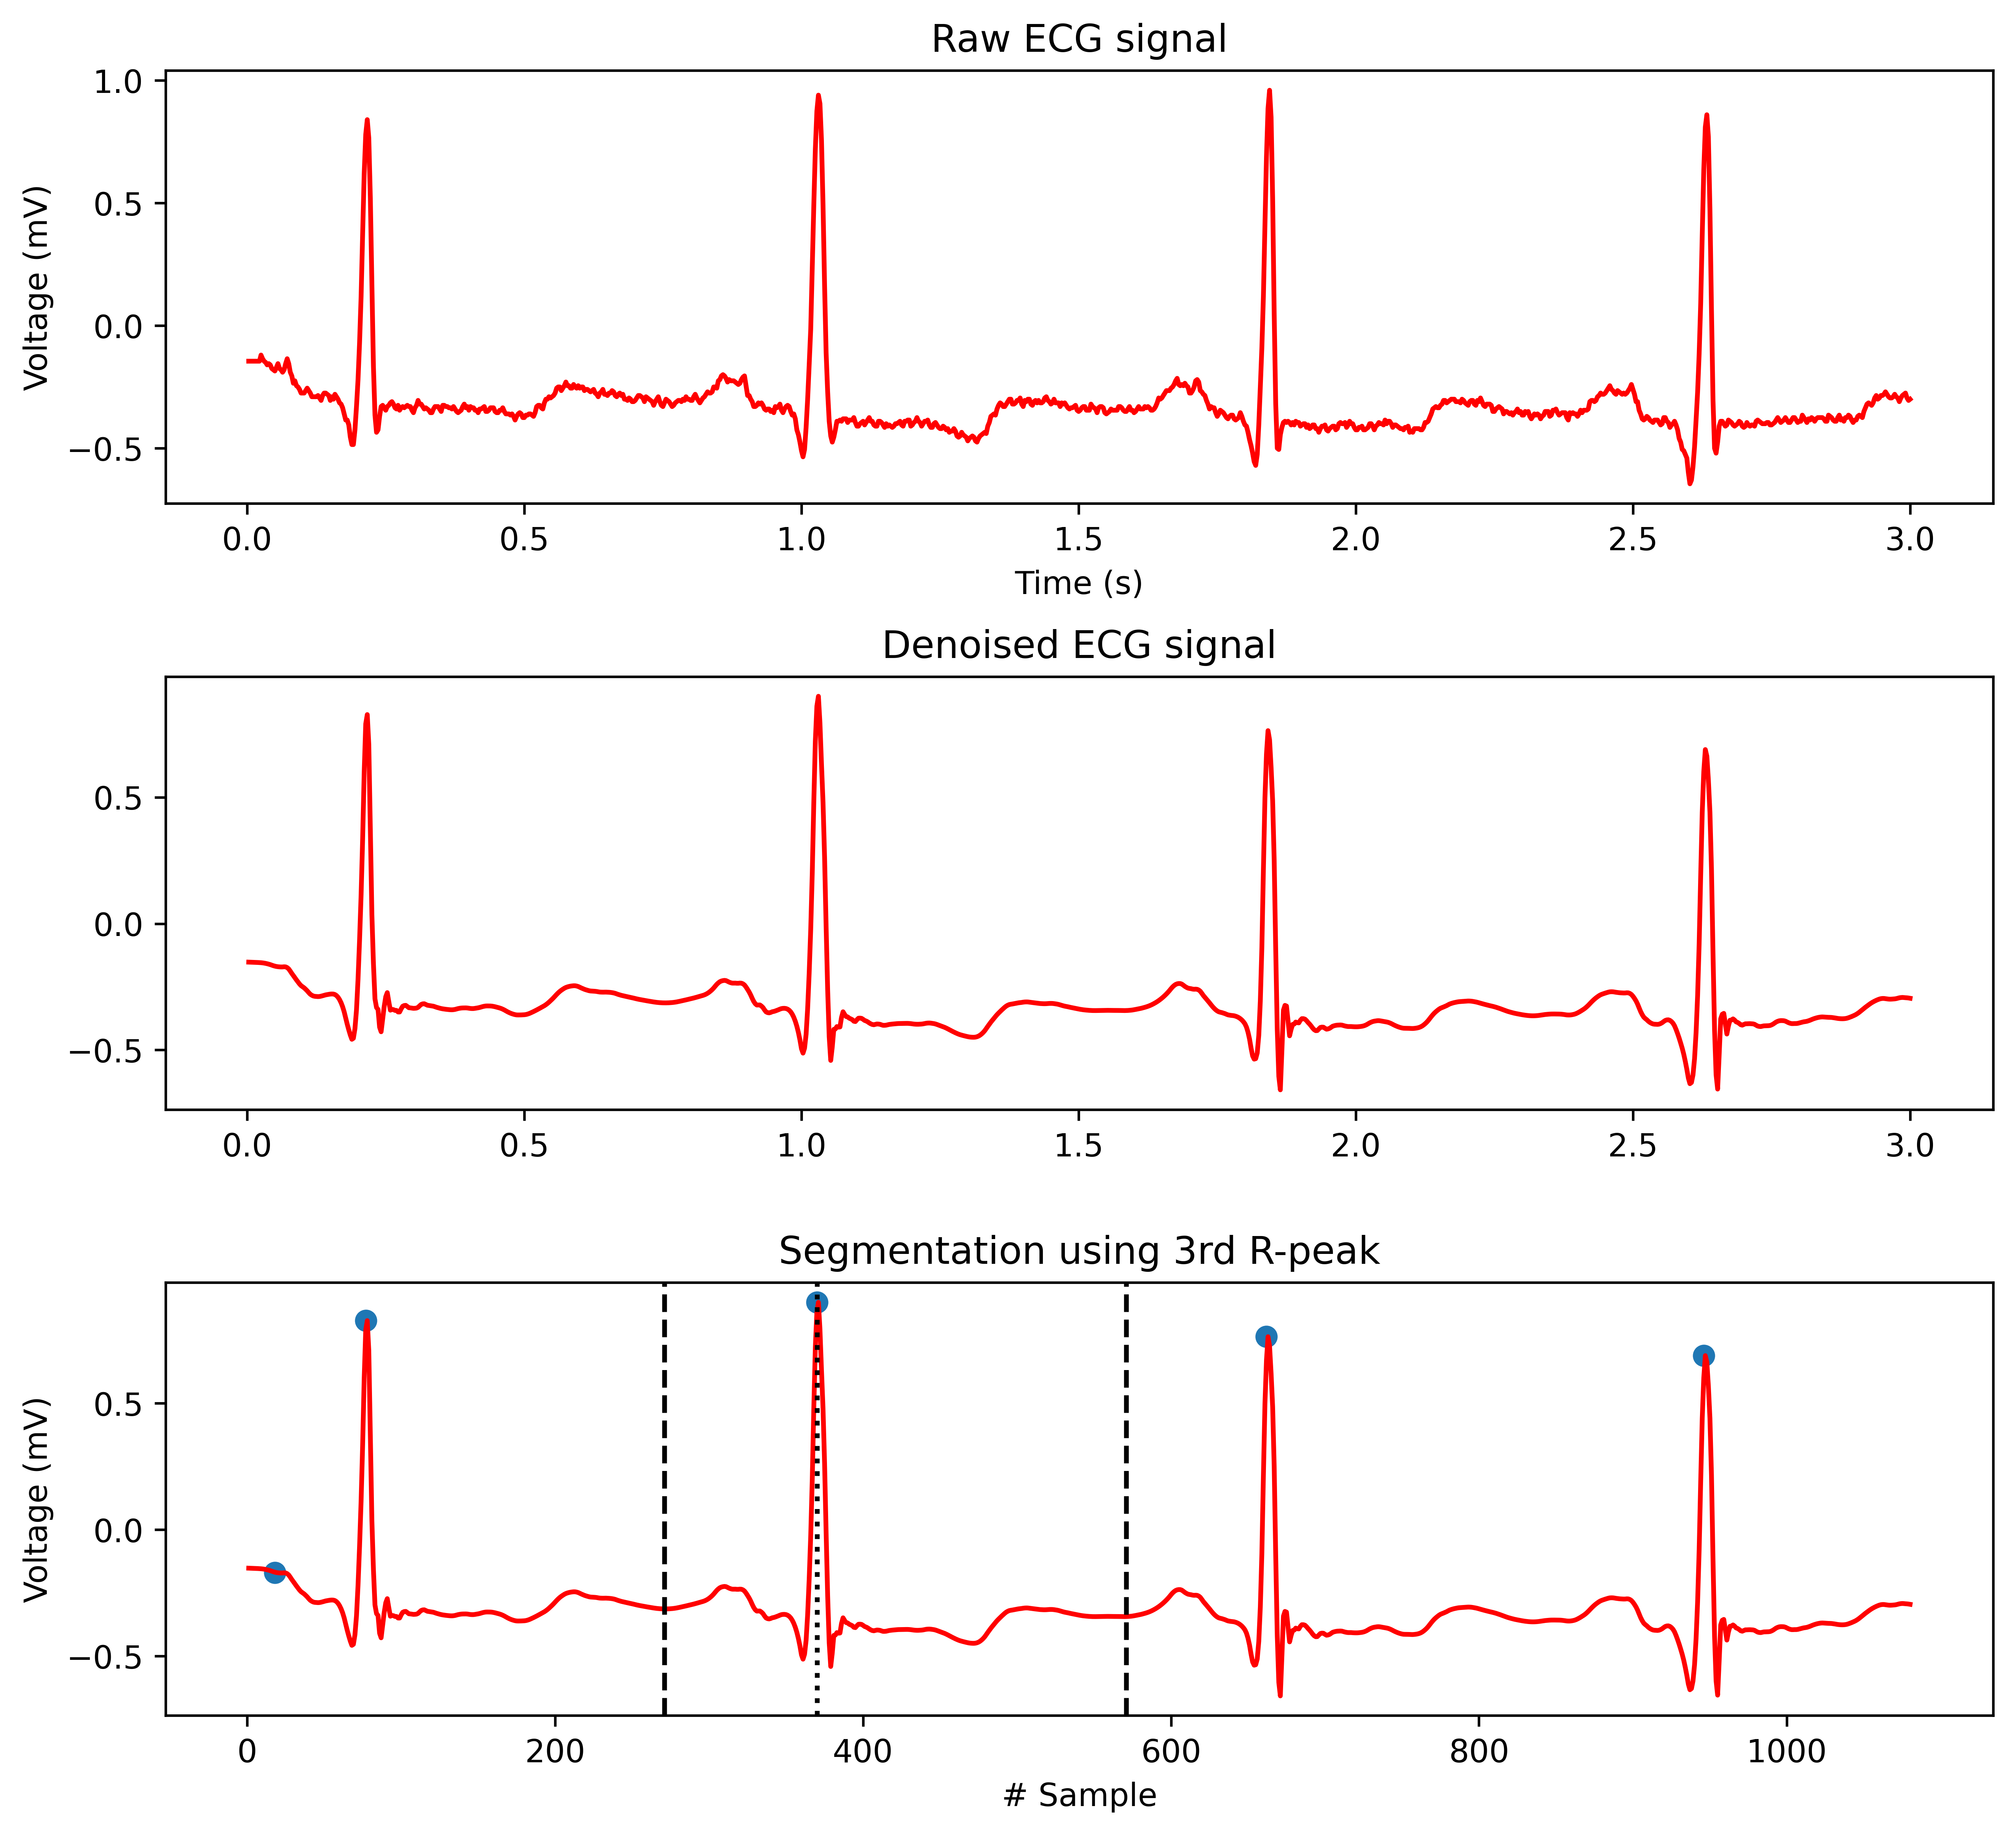

In [ ]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

# **Part C: Dataset Loading**

## **C1: Loading whole data**

In [ ]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [ ]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         2.0: 7244,
         12.0: 7012,
         9.0: 7123,
         1.0: 8063,
         5.0: 2540,
         11.0: 802,
         6.0: 150,
         13.0: 982,
         10.0: 106,
         7.0: 83,
         4.0: 229,
         14.0: 33,
         3.0: 16,
         8.0: 2})

## **C2: Ploting 15 Different Heartbeats**

In [ ]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [ ]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [ ]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']

  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)',
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)',
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)',
                  'Supraventricular prem. (S)', 'Premature ventr. (V)',
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)',
                  'Paced (/)', 'Fusion of pa. & no. (f)',
                  'Unclassifiable(Q)']

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)

  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

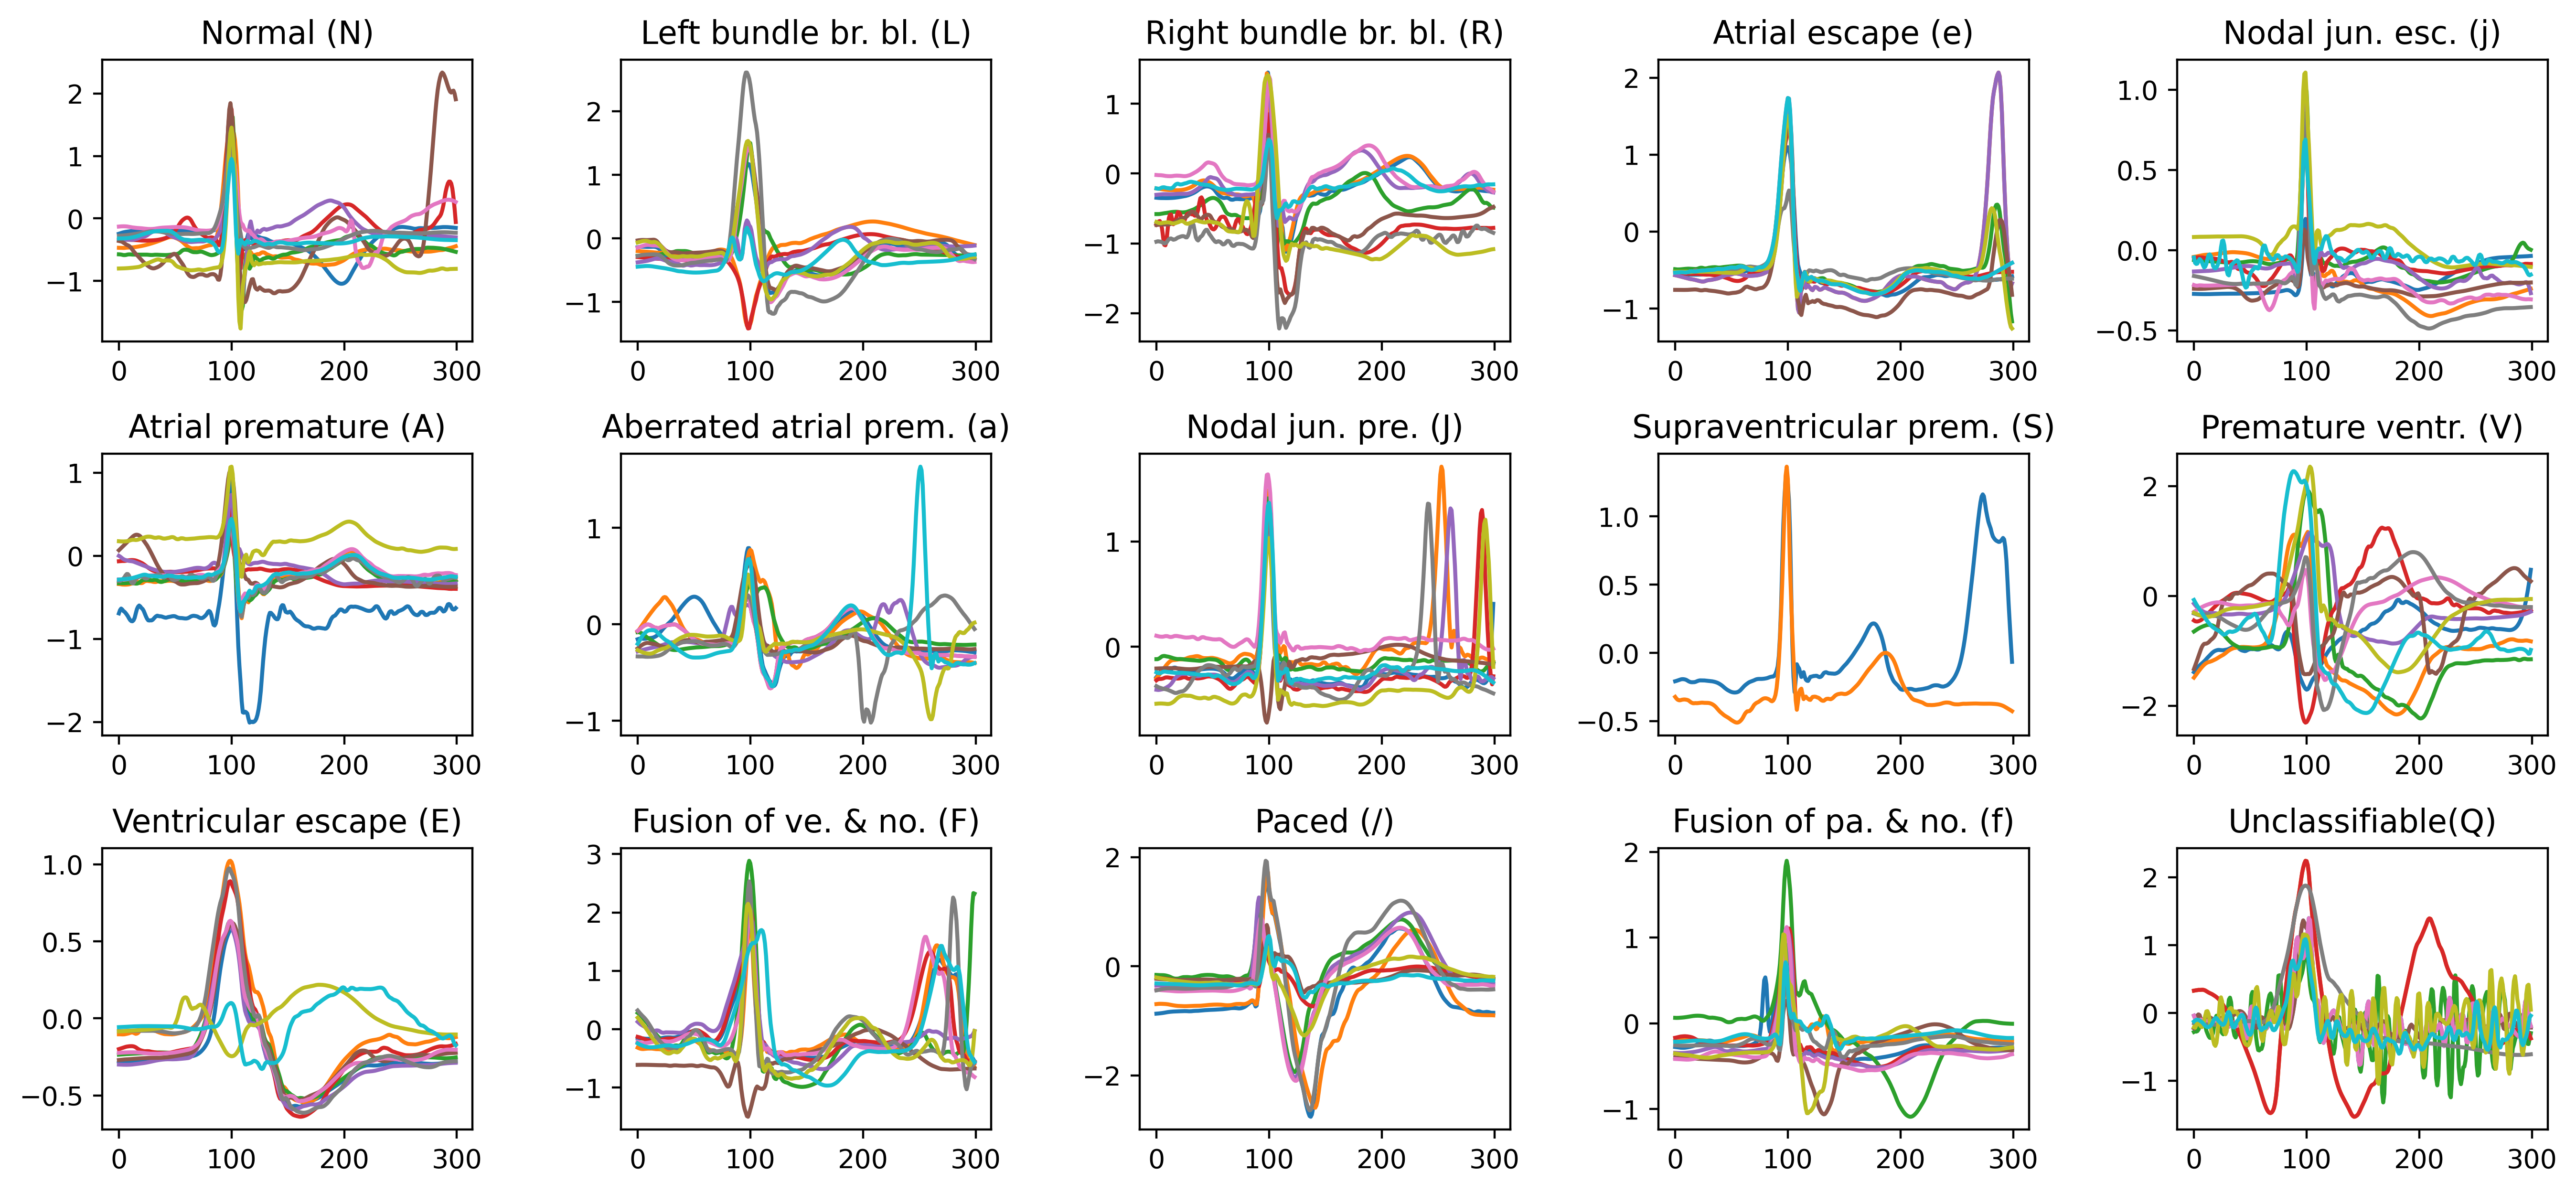

In [ ]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'all_heartbeats.png')

# **Part D: Train-Test Splitting and Class Balancing**

## **D1: Data loading**


### **a. Load whole data**

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [ ]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

reading 100 ECG data...
Channels: MLII, V5
reading 101 ECG data...
Channels: MLII, V1
reading 102 ECG data...
Channels: V5, V2
reading 103 ECG data...
Channels: MLII, V2
reading 104 ECG data...
Channels: V5, V2
reading 105 ECG data...
Channels: MLII, V1
reading 106 ECG data...
Channels: MLII, V1
reading 107 ECG data...
Channels: MLII, V1
reading 108 ECG data...
Channels: MLII, V1
reading 109 ECG data...
Channels: MLII, V1
reading 111 ECG data...
Channels: MLII, V1
reading 112 ECG data...
Channels: MLII, V1
reading 113 ECG data...
Channels: MLII, V1
reading 114 ECG data...
Channels: V5, MLII
reading 115 ECG data...
Channels: MLII, V1
reading 116 ECG data...
Channels: MLII, V1
reading 117 ECG data...
Channels: MLII, V2
reading 118 ECG data...
Channels: MLII, V1
reading 119 ECG data...
Channels: MLII, V1
reading 121 ECG data...
Channels: MLII, V1
reading 122 ECG data...
Channels: MLII, V1
reading 123 ECG data...
Channels: MLII, V5
reading 124 ECG data...
Channels: MLII, V4
reading 200 ECG

In [ ]:
Y = train_ds[:, 300]

In [ ]:
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         2.0: 7244,
         13.0: 982,
         1.0: 8063,
         11.0: 802,
         12.0: 7012,
         9.0: 7123,
         5.0: 2540,
         7.0: 83,
         6.0: 150,
         3.0: 16,
         10.0: 106,
         4.0: 229,
         14.0: 33,
         8.0: 2})

### **b. 15 types to 5 level conversion**

In [ ]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [ ]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 3.0: 802, 2.0: 7229, 1.0: 2775})

In [ ]:
ecg_dataset = np.copy(train_ds)

In [ ]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [ ]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [ ]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

## **D2: Train-Test Spliting**


In [ ]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [ ]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [ ]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [ ]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

## **D3: Class balancing by undersampling and SMOTE**
**SMOTE** stands for '**Synthetic Minority Oversampling Technique**'.
Plan for train data
1. Class 1: Randomly selected 50000 data
2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

In [ ]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [ ]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [ ]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (50000) in class 1 will be larger than the number of samples in the majority class (class #4.0 -> 6414)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #4.0 -> 6414)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (50000) in class 3 will be larger than the number of samples in the majority class (class #4.0 -> 6414)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (50000) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 6414)
  warnings.wa

In [ ]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.53111815, -0.53368839, -0.53573609, ..., -0.55735758,
        -0.5732545 ,  0.        ],
       [-0.08370364, -0.07995894, -0.07650575, ..., -0.24742872,
        -0.24595256,  2.        ],
       [-0.40633884, -0.41541856, -0.42478188, ..., -0.57149581,
        -0.36978346,  3.        ],
       ...,
       [-0.24908516, -0.24692305, -0.24490944, ..., -0.35527968,
        -0.3524847 ,  0.        ],
       [-0.10023924, -0.09833107, -0.09902252, ..., -0.06756377,
        -0.06525144,  1.        ],
       [-0.17283411, -0.17209645, -0.17105622, ..., -0.19361472,
        -0.19419331,  0.        ]])

In [ ]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

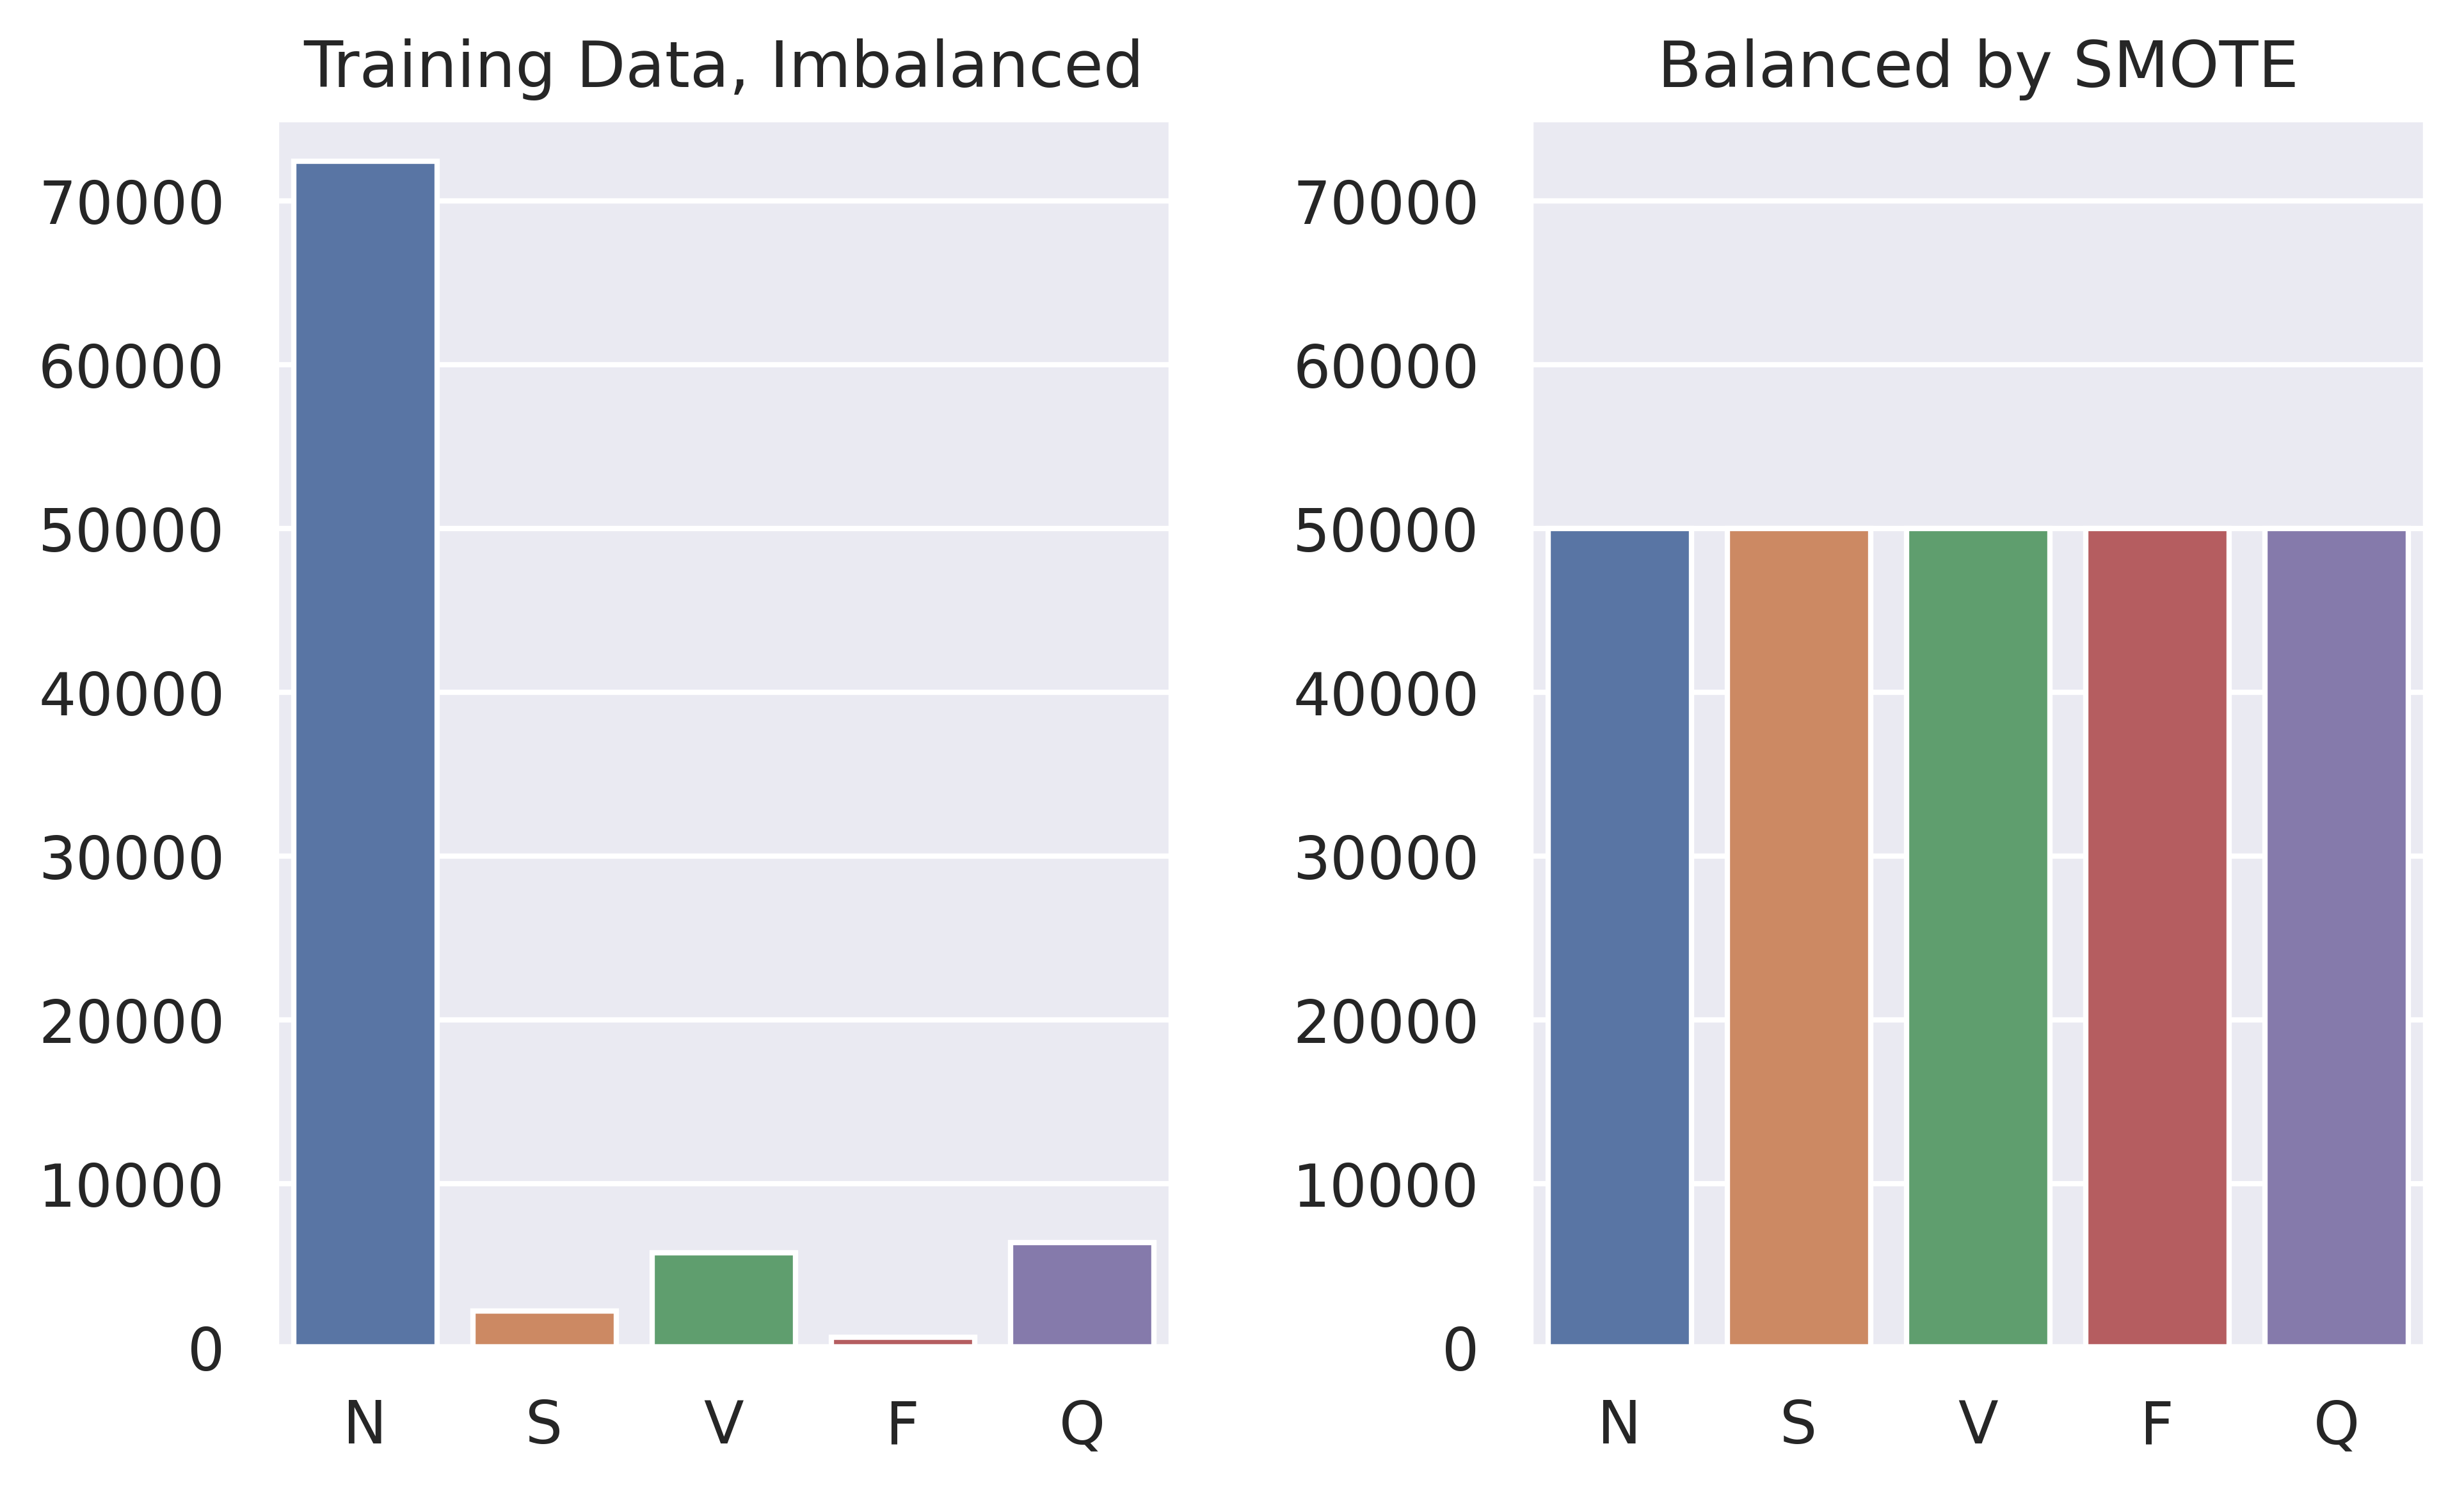

In [ ]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'Class balancing.png')

# **Part E: Model Building and Training**
A **CNN-LSTM and attention** based hybrid model is formulated.

## **E1: Attention Mechanism**
**Convolutional Block Attention Module** ([CBAM](https://arxiv.org/abs/1807.06521)) consists two parts (i) **channel attention**, (ii) spatial attention. ECG is an 1D signal and 1-lead ECG is used in the modle.Therefore, only channel attention is only used.

In [ ]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

## **E2: CNN-LSTM and attention model architecture**

### **a. Model building**

In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),

        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),

        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),

        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),

        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),

        tf.keras.layers.LSTM(64, return_sequences=True),

        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.LSTM(32, return_sequences=True),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),

        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **b. Hyperparameter Tuning**


In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),

        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),

        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),

        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),

        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),

        tf.keras.layers.LSTM(128, return_sequences=True),

        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.LSTM(64, return_sequences=True),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),

        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **c. Model Training**

In [ ]:
logdir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model_code 17_t5.h5"

In [ ]:
if os.path.exists(model_path):

  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:

  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

  checkpoint_filepath=project_path + "code_17_t5_weights.hdf5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]

  history = model.fit(X_train, Y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 300, 16)           352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 32)           11808     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 75, 64)            51264     
                                                                 
 average_p

### **d. Plotting Accuracy and Loss**
Training and Validation accuray and loss curve plotting.

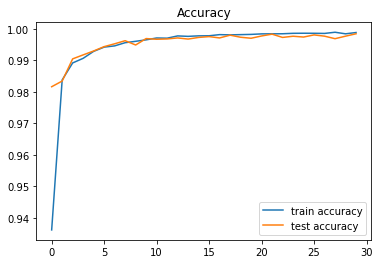

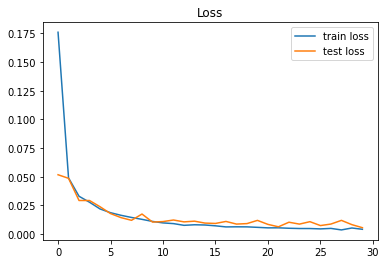

In [ ]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# **Part F: Results**


## **F1: Classification Accuracy and Confusion Matrix**

**a. Using Recently Trained Model**

In [ ]:
# evaluate the model
file_name = project_path + 'train_data_smote_tomek.pkl'
train_data_smote_tomek = pd.read_pickle(file_name)
file_name = project_path + 'test_data.pkl'
test_data = pd.read_pickle(file_name)
train_data_numpy = train_data_smote_tomek.to_numpy()
test_data_numpy = test_data.to_numpy()
X_train = train_data_numpy[:, :300]
Y_train = train_data_numpy[:, 300]

X_test = test_data_numpy[:, :300]
Y_test = test_data_numpy[:, 300]
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.93, Test Accuracy: 99.12
Training Loss: 0.23, Test Loss: 5.95


**b. Using the Best Model**
We saved many checkpoints of the model. Among these checkpoints we will consider the checkpoint which has the largest validation accuracy. Then copy its path and update the model weights.

In [ ]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

In [ ]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(X_train, Y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(X_test, Y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

Training Accuracy: 99.93, Test Accuracy: 99.12
Training Loss: 0.23, Test Loss: 5.95


**Confusion Matrix**

In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

684/684 [==============================] - 4s 4ms/step


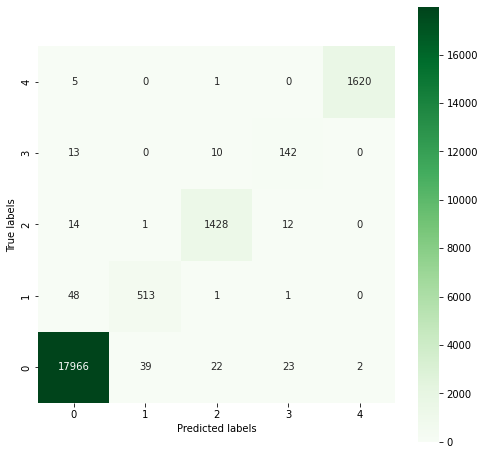

In [ ]:
# predict
Y_pred = np.argmax(model.predict(X_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(Y_test, Y_pred)

## **F2: Per Class Performance**
Calculating per class Sensitivity, Specificity, Accuracy and F1 score.

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

**a. Recently Trained Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 [==============================] - 3s 4ms/step


,N,S,V,F,Q
Sensitivity (%),99.523598,91.119005,98.144330,86.060606,99.630996
Specificity (%),97.899711,99.812189,99.833382,99.834071,99.990116
F1 Score (%),99.540141,91.935484,97.908810,82.798834,99.753695
Per Class Accuracy (%),99.240657,99.588308,99.720964,99.730113,99.963405


**b. Best Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model2.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 [==============================] - 4s 5ms/step


,N,S,V,F,Q
Sensitivity (%),99.523598,91.119005,98.144330,86.060606,99.630996
Specificity (%),97.899711,99.812189,99.833382,99.834071,99.990116
F1 Score (%),99.540141,91.935484,97.908810,82.798834,99.753695
Per Class Accuracy (%),99.240657,99.588308,99.720964,99.730113,99.963405
